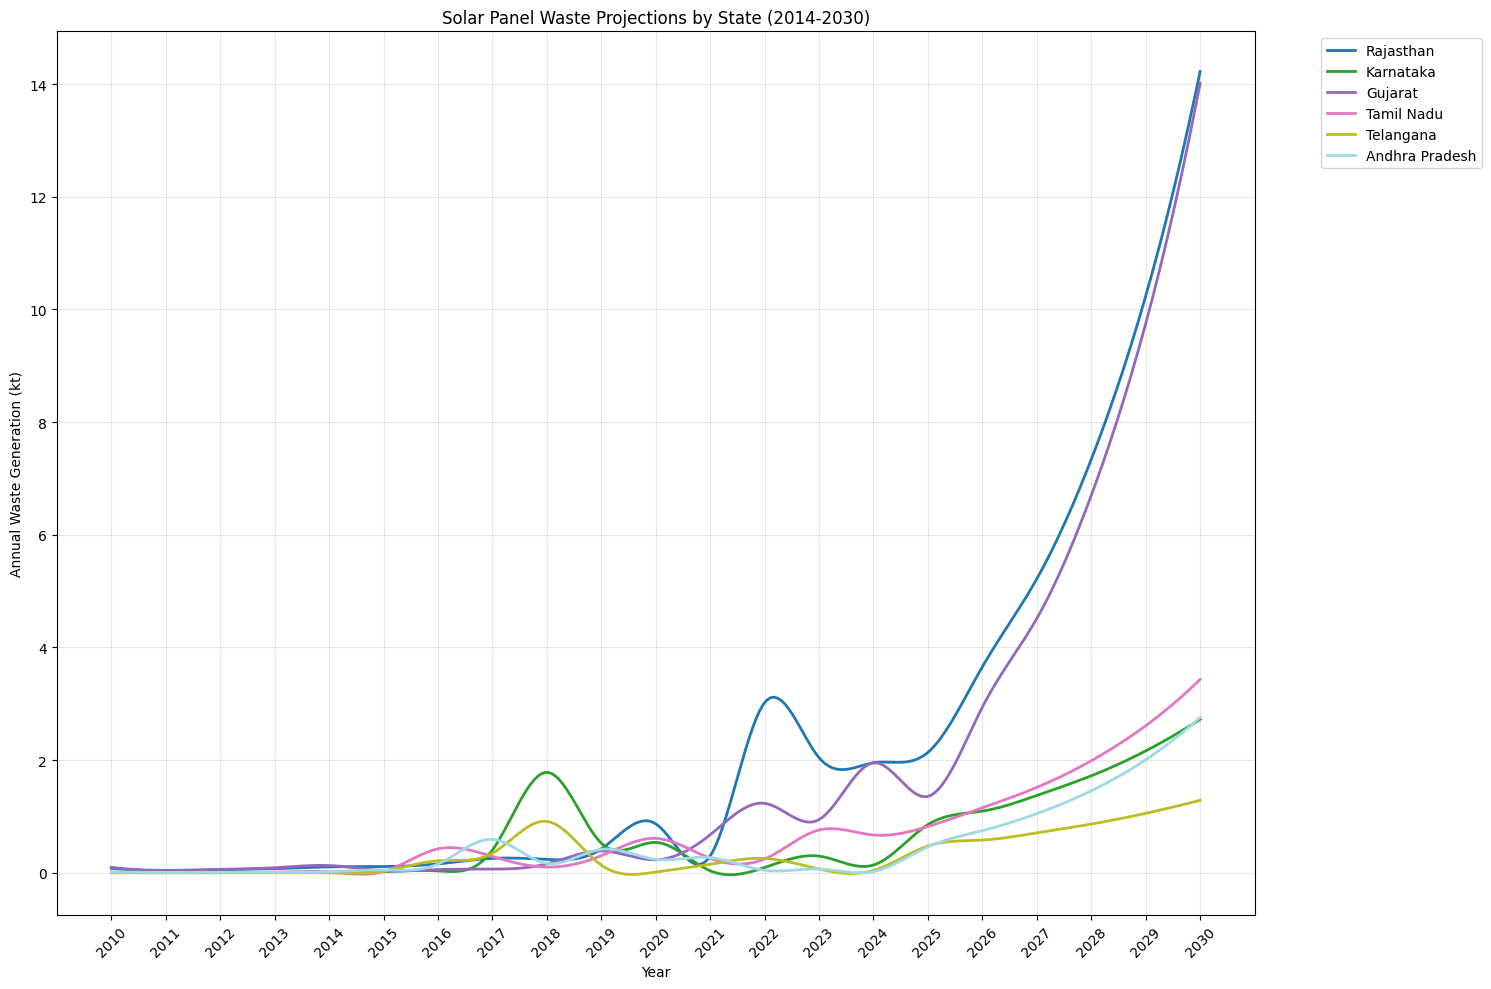

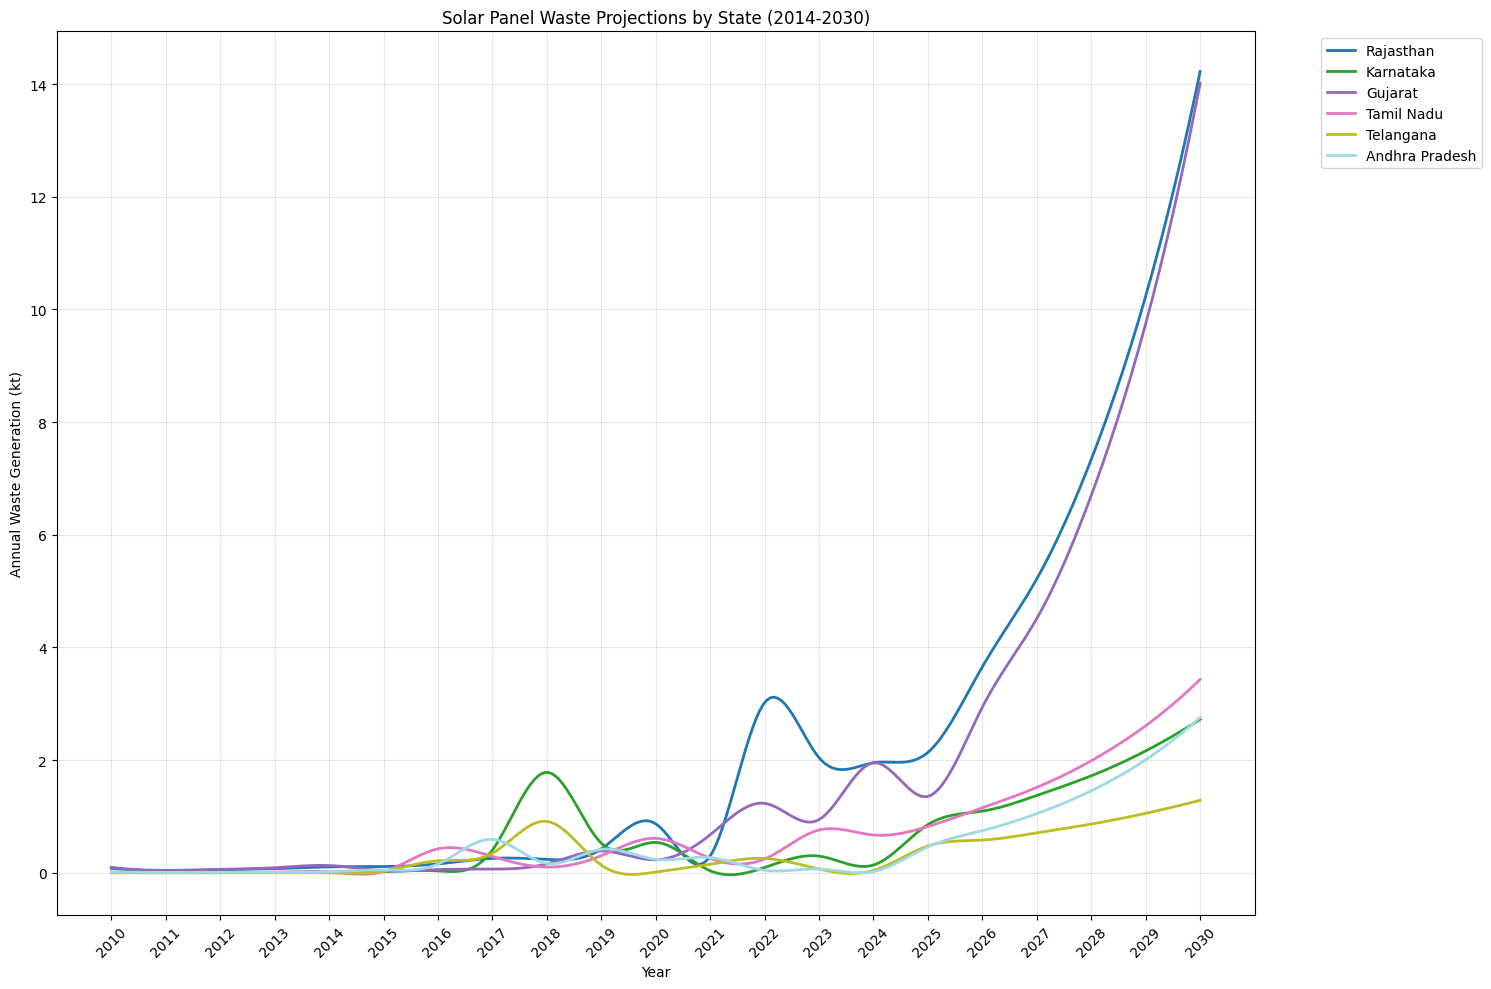

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import weibull_min
from scipy.interpolate import make_interp_spline

def calculate_eol_year(installation_year, dr):
    """Calculate End of Life year based on degradation rate"""
    performance = 100
    years = 0
    while performance >= 80:  # EOL when performance drops below 80%
        performance = performance - dr * performance
        years += 1
    return installation_year + years

class MultiStateSolarWasteModel:
    def __init__(self):
        self.MODULE_MASS = 65  # tonnes per MW
        self.T_H_COEFF = 0.002  # Transportation and handling coefficient (0.2%)
        self.PO_COEFF = 0.005  # Project operation coefficient (0.5%)
        self.BASE_DR = 0.014    # Base case degradation rate (1.4%)
        self.CB_RL_DR = 0.0082  # Regular loss degradation rate (0.82%)
        
    def process_historical_data(self, csv_path):
        """Process historical installation data by state"""
        df = pd.read_csv(csv_path)
        df.columns = df.columns.str.strip()
        df = df[df['STATES / Uts'].notna()]
        # Filter out 'Total' and 'Others'
        df = df[~df['STATES / Uts'].isin(['Total', 'Others'])]
        
        year_cols = [str(year) for year in range(2014, 2025)]
        for col in year_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
        # Fill NaN values with 0
        df = df.fillna(0)
        
        return df
    
    def generate_future_projections(self, historical_data, state):
        """Generate future projections for a specific state"""
        state_data = historical_data[historical_data['STATES / Uts'] == state]
        
        years = list(range(2014, 2025))
        installations = state_data.iloc[0, 2:13].values
        
        past_years = list(range(2010, 2014))
        historical_installations = []
        for i in range(len(past_years) - 1):
            if i == 0:
                historical_installations.insert(0, installations[0] / (1 + 0.44))
            historical_installations.insert(0, historical_installations[0] / (1 + 0.44))
        
        future_years = list(range(2025, 2031))
        future_installations = []
        last_installation = installations[-1]
        
        growth_rate = 0.22
        
        for i, _ in enumerate(future_years):
            next_value = last_installation * (1 + growth_rate)
            future_installations.append(next_value)
            last_installation = next_value
            
        all_years = past_years + years + future_years
        all_installations = historical_installations + list(installations) + future_installations
        
        annual_installations = [all_installations[0]]
        for i in range(1, len(all_installations)):
            annual_installations.append(all_installations[i] - all_installations[i-1])
            
        return pd.DataFrame({
            'Year': all_years,
            'Capacity_MW': all_installations,
            'Annual_installation': annual_installations
        })
    
    def coefficient_based_waste(self, df, dr):
        """Calculate waste using coefficient-based approach"""
        waste_by_year = []
        total_waste = 0
        
        for year in df['Year']:
            year_waste = 0
            
            for install_year in range(2010, year+1):
                idx = df['Year'] == install_year
                if not any(idx):
                    continue
                    
                capacity = df.loc[idx, 'Annual_installation'].values[0]
                mass = capacity * self.MODULE_MASS
                
                if year == install_year:
                    th_waste = mass * self.T_H_COEFF
                    year_waste += th_waste
                    po_waste = mass * self.PO_COEFF
                    year_waste += po_waste
                
                eol_year = calculate_eol_year(install_year, dr)
                if year >= eol_year:
                    remaining_mass = mass - (mass * self.T_H_COEFF) - (mass * self.PO_COEFF * (eol_year - install_year))
                    if year == eol_year:
                        eol_waste = remaining_mass * 0.1
                    elif year == eol_year + 1:
                        eol_waste = remaining_mass * 0.15
                    elif year == eol_year + 2:
                        eol_waste = remaining_mass * 0.20
                    elif year == eol_year + 3:
                        eol_waste = remaining_mass * 0.25
                    elif year == eol_year + 4:
                        eol_waste = remaining_mass * 0.30
                    else:
                        eol_waste = 0
                    year_waste += eol_waste
            
            total_waste = year_waste
            waste_by_year.append(total_waste)
            
        return waste_by_year

    def plot_all_states(self, historical_data, top_n=6):
        """Plot waste projections for all states in a single graph"""
        plt.figure(figsize=(15, 10))
        
        # Calculate total capacity for each state to identify top states
        state_totals = historical_data.iloc[:, 2:13].sum(axis=1)
        top_states = state_totals.nlargest(top_n).index
        top_state_names = historical_data.loc[top_states, 'STATES / Uts']
        
        # Color map for different states
        colors = plt.cm.tab20(np.linspace(0, 1, top_n))
        
        for i, state in enumerate(top_state_names):
            df = self.generate_future_projections(historical_data, state)
            base_case = self.coefficient_based_waste(df, self.BASE_DR)
            
            # Convert to kilotonnes
            base_case = [w/1000 for w in base_case]
            
            # Interpolation for smooth curve
            x_new = np.linspace(df['Year'].min(), df['Year'].max(), 300)
            spl = make_interp_spline(df['Year'], base_case, k=3)
            base_case_smooth = spl(x_new)
            
            plt.plot(x_new, base_case_smooth, color=colors[i], label=state, linewidth=2)
        
        plt.grid(True, alpha=0.3)
        plt.xlabel('Year')
        plt.ylabel('Annual Waste Generation (kt)')
        plt.title('Solar Panel Waste Projections by State (2014-2030)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(df['Year'][::1],rotation=45)
        
        plt.tight_layout()
        return plt.gcf()

def analyze_all_states(csv_path):
    """Analyze and plot waste generation for all states"""
    model = MultiStateSolarWasteModel()
    historical_data = model.process_historical_data(csv_path)
    fig = model.plot_all_states(historical_data)
    return fig

# Example usage:
analyze_all_states('Solar Waste prediction.csv')